# Diabetes Prediction using Schorling diabetes dataset.

**Novelty created by:** Yichen Shi, Jingyu Wang <br>
**Summary:** <br> In this notebook, we replace the original dataset with a new diabetes dataset, to test the performance of the proposed models.The new data consists of 19 variables on 403 subjects. The response variable is 'glyhb', which is numerical.Glycosolated hemoglobin > 7.0 is usually taken as a positive diagnosis of diabetes. The data is available at  http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Diabetes.html. In the following parts, we'll perform data cleaning, data prepossessing, and feed the inputs data into the models.

## Load packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set(style="whitegrid")
import warnings 
from sklearn.svm import SVC, NuSVC
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
# from tflearn.data_utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy import interp
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from tensorflow.keras.utils import to_categorical

## Data Cleaning

In [26]:
# import the new dataset
ddata = pd.read_csv('Diabetes2.csv')
ddata.head(5)

,id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn
0,1000,203.0,82,56.0,3.6,4.31,Buckingham,46,female,62.0,121.0,medium,118.0,59.0,NaN,NaN,29.0,38.0,720.0
1,1001,165.0,97,24.0,6.9,4.44,Buckingham,29,female,64.0,218.0,large,112.0,68.0,NaN,NaN,46.0,48.0,360.0
2,1002,228.0,92,37.0,6.2,4.64,Buckingham,58,female,61.0,256.0,large,190.0,92.0,185.0,92.0,49.0,57.0,180.0
3,1003,78.0,93,12.0,6.5,4.63,Buckingham,67,male,67.0,119.0,large,110.0,50.0,NaN,NaN,33.0,38.0,480.0
4,1005,249.0,90,28.0,8.9,7.72,Buckingham,64,male,68.0,183.0,medium,138.0,80.0,NaN,NaN,44.0,41.0,300.0


In [27]:
# Transform the response variable into binary, transform categorical variables into dummies
# Drop rows with unrecorded 'glyhb' and some variables
ddata = ddata[ddata['glyhb'].isnull() != True]
dummy = pd.get_dummies(ddata['gender'])
ddata = pd.concat([ddata, dummy], axis = 1)
ddata['outcome'] = (ddata['glyhb'] > 7).replace({False: 0, True: 1})
ddata = ddata.drop(columns=['id', 'gender','glyhb','location','frame','bp.2s','bp.2d','time.ppn'])
ddata.head(5)

,chol,stab.glu,hdl,ratio,age,height,weight,bp.1s,bp.1d,waist,hip,female,male,outcome
0,203.0,82,56.0,3.6,46,62.0,121.0,118.0,59.0,29.0,38.0,1,0,0
1,165.0,97,24.0,6.9,29,64.0,218.0,112.0,68.0,46.0,48.0,1,0,0
2,228.0,92,37.0,6.2,58,61.0,256.0,190.0,92.0,49.0,57.0,1,0,0
3,78.0,93,12.0,6.5,67,67.0,119.0,110.0,50.0,33.0,38.0,0,1,0
4,249.0,90,28.0,8.9,64,68.0,183.0,138.0,80.0,44.0,41.0,0,1,1


In [28]:
ddata.shape

(390, 14)

In [29]:
# renaming the data
data = pd.DataFrame({'F1':ddata.iloc[:,:14].values[:,0],
                     'F2':ddata.iloc[:,:14].values[:,1],
                     'F3':ddata.iloc[:,:14].values[:,2],
                     'F4':ddata.iloc[:,:14].values[:,3],
                     'F5':ddata.iloc[:,:14].values[:,4],
                     'F6':ddata.iloc[:,:14].values[:,5],
                     'F7':ddata.iloc[:,:14].values[:,6],
                     'F8':ddata.iloc[:,:14].values[:,7],
                     'F9':ddata.iloc[:,:14].values[:,8],
                     'F10':ddata.iloc[:,:14].values[:,9],
                     'F11':ddata.iloc[:,:14].values[:,10],
                     'F12':ddata.iloc[:,:14].values[:,11],
                     'F13':ddata.iloc[:,:14].values[:,12],       
                     'Outcome':ddata.iloc[:,:14].values[:,13]})

In [30]:
data.head(5)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,Outcome
0,203.0,82.0,56.0,3.6,46.0,62.0,121.0,118.0,59.0,29.0,38.0,1.0,0.0,0.0
1,165.0,97.0,24.0,6.9,29.0,64.0,218.0,112.0,68.0,46.0,48.0,1.0,0.0,0.0
2,228.0,92.0,37.0,6.2,58.0,61.0,256.0,190.0,92.0,49.0,57.0,1.0,0.0,0.0
3,78.0,93.0,12.0,6.5,67.0,67.0,119.0,110.0,50.0,33.0,38.0,0.0,1.0,0.0
4,249.0,90.0,28.0,8.9,64.0,68.0,183.0,138.0,80.0,44.0,41.0,0.0,1.0,1.0


In [31]:
# check null values
# replace null values with mean
l = ['F1','F3','F4','F6','F7','F8','F9','F10','F11','F12','F13']
for i in l:
    data[i].fillna((data[i].mean()), inplace=True)

In [32]:
data.describe()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,Outcome
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,207.275064,107.338462,50.267352,4.526478,46.774359,65.984416,177.349614,137.148052,83.285714,37.896907,43.033505,0.584615,0.415385,0.153846
std,44.657438,53.798188,17.279064,1.736244,16.435911,3.900401,40.391543,22.849151,13.494793,5.747890,5.634672,0.493421,0.493421,0.361265
min,78.000000,48.000000,12.000000,1.500000,19.000000,52.000000,99.000000,90.000000,48.000000,26.000000,30.000000,0.000000,0.000000,0.000000
25%,179.000000,81.000000,38.000000,3.200000,34.000000,63.000000,150.250000,122.000000,75.000000,33.000000,39.000000,0.000000,0.000000,0.000000
50%,203.500000,90.000000,46.000000,4.200000,44.500000,66.000000,173.000000,136.000000,82.000000,37.000000,42.000000,1.000000,0.000000,0.000000
75%,229.000000,107.750000,59.000000,5.400000,60.000000,69.000000,199.750000,148.000000,90.000000,41.000000,46.000000,1.000000,1.000000,0.000000
max,443.000000,385.000000,120.000000,19.299999,92.000000,76.000000,325.000000,250.000000,124.000000,56.000000,64.000000,1.000000,1.000000,1.000000


In [33]:
data.isnull().any()

F1         False
F2         False
F3         False
F4         False
F5         False
F6         False
F7         False
F8         False
F9         False
F10        False
F11        False
F12        False
F13        False
Outcome    False
dtype: bool

## Define utility function

In [34]:
Renamed_feature= []               
all_clf_res=[]                    
random_initializer=100            
n_dots=50

for i in range(13):
  #for renaming dataset of columns features F1 to F13
  Renamed_feature.append('F'+str(i+1)) 


    
# Pairs plots
def pair_plot(data):
  plt.figure()
  
  pair_plot =sns.pairplot(data=data,            
                          height=3,
                          hue='Outcome',  
                          diag_kind='kde')
  pair_plot.fig.suptitle("Pairplot of all features")
  plt.show()


# Gaussian distribution plot and box plot 
def Box_Gaussian(data):
  
  fig=plt.figure(figsize=(15,6))                                
  fig.suptitle("Box Gaussian plot of all features")
  
  n_scaler = preprocessing.StandardScaler()                
  temp_Data = n_scaler.fit_transform(data)
  
  #loop for all 13 features 
  for i in range(13):                                        
    
    plt.subplot(3, 5, i+1)                                 
    Data = temp_Data[:,i]                                   
    sns.kdeplot(Data, shade=True,color='red', alpha=0.3)    
    ax = sns.boxplot(Data, saturation=0.9, color="green")   
                                                            
                                                            
    plt.gca().invert_yaxis()                                
    plt.title('F'+str(i+1))
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])                   
    plt.ylim((-0.5,0.65))                                   
    plt.tight_layout()                                      
                                                              
    for patch in ax.artists:
      r, g, b, a = patch.get_facecolor()                     
      patch.set_facecolor((r, g, b, 0.3))                   


# confusion matrix plot
def plot_confusionMatrix(data):
  
  sns.set(font_scale=1.15)                                   
  ax = plt.figure(figsize=(10, 8))                            
  plt.title("Confusion Matrix of all features")
  sns.heatmap(data.corr(),                                   
              vmax=1.0,                                       
                                                             
              vmin=0.0,
              linewidths=0.01,
              square=False,                                   
              annot=True,                                    
              linecolor="black")                                    
                                                          
  b, t = plt.ylim()                                           
  b += 0.5                                                    
  t -= 0.5                                                  
  plt.ylim(b, t)                                          
  plt.show() 




# univariate distribution plot
def dist_Plot(data):
 
  fig, ax = plt.subplots(3,5, figsize=(12,5))                 
  sns.set()
  sns.distplot(data.F1, bins = 10, ax=ax[0,0])                
  sns.distplot(data.F2, bins = 10, ax=ax[0,1]) 
  sns.distplot(data.F3, bins = 10, ax=ax[0,2]) 
  sns.distplot(data.F4, bins = 10, ax=ax[0,3])
  sns.distplot(data.F5, bins = 10, ax=ax[0,4])
  sns.distplot(data.F6, bins = 10, ax=ax[1,0]) 
  sns.distplot(data.F7, bins = 10, ax=ax[1,1]) 
  sns.distplot(data.F8, bins = 10, ax=ax[1,2]) 
  sns.distplot(data.F9, bins = 10, ax=ax[1,3])
  sns.distplot(data.F10, bins = 10, ax=ax[1,4])
  sns.distplot(data.F11, bins = 10, ax=ax[2,0])
  sns.distplot(data.F12, bins = 10, ax=ax[2,1])
  sns.distplot(data.F13, bins = 10, ax=ax[2,2])
  fig.suptitle("Gaussian Distribution of all features")
  fig.tight_layout()                                        



# violin plots
def plot_violinplot (data):
  
  fig, ax = plt.subplots(3,5, figsize=(12,6))          
  # #set numbers of rows and columns of subplot and figure size 
  sns.set()
  sns.violinplot(x = data.Outcome, y=data.F1,  ax=ax[0,0])    
  sns.violinplot(x = data.Outcome, y=data.F2,  ax=ax[0,1])     
  sns.violinplot(x = data.Outcome, y=data.F3,  ax=ax[0,2])    
  sns.violinplot(x = data.Outcome, y=data.F4,  ax=ax[0,3])
  sns.violinplot(x = data.Outcome, y=data.F5, ax=ax[0,4])
  sns.violinplot(x = data.Outcome, y=data.F6,  ax=ax[1,0])    
  sns.violinplot(x = data.Outcome, y=data.F7,  ax=ax[1,1])    
  sns.violinplot(x = data.Outcome, y=data.F8,  ax=ax[1,2])   
  sns.violinplot(x = data.Outcome, y=data.F9,  ax=ax[1,3])
  sns.violinplot(x = data.Outcome, y=data.F10, ax=ax[1,4])
  sns.violinplot(x = data.Outcome, y=data.F11,  ax=ax[2,0])
  sns.violinplot(x = data.Outcome, y=data.F12,  ax=ax[2,1])
  sns.violinplot(x = data.Outcome, y=data.F13,  ax=ax[2,2])
  fig.suptitle("Violin plot of all features")
  fig.tight_layout()

                                                              

    
def data_plot (data,
               Pair_plot,
               Dist_Plot,
               Plot_violinplot,
               Plot_confusionMatrix,
               box_Gaussian):
  
  if Pair_plot ==True:
    pair_plot(data)

  if Dist_Plot ==True:
    dist_Plot(data)

  if Plot_violinplot ==True:
    plot_violinplot (data)

  if Plot_confusionMatrix ==True:
    plot_confusionMatrix(data)

  if box_Gaussian ==True:
    Box_Gaussian(data)


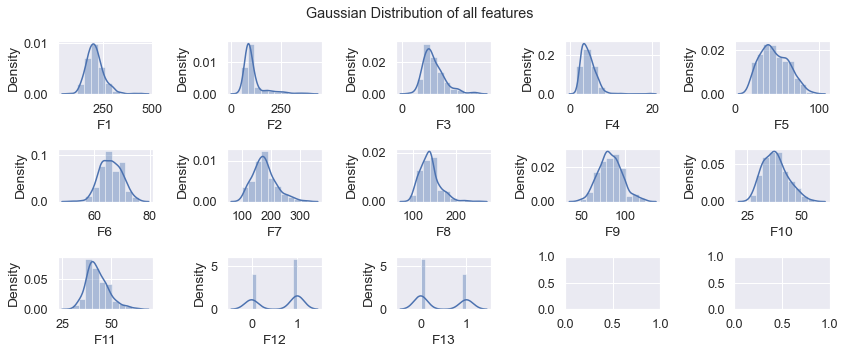

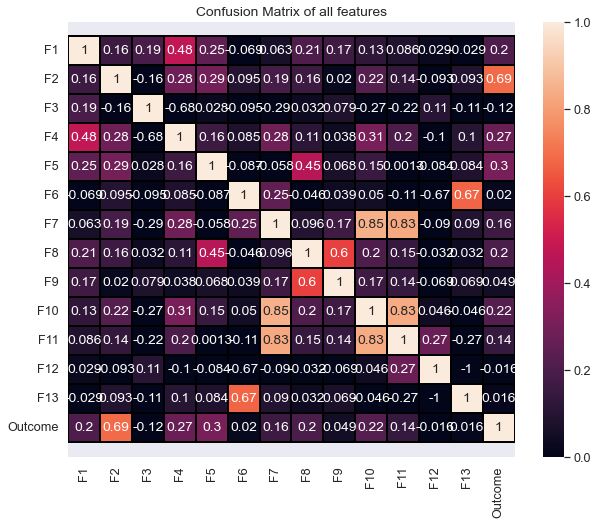

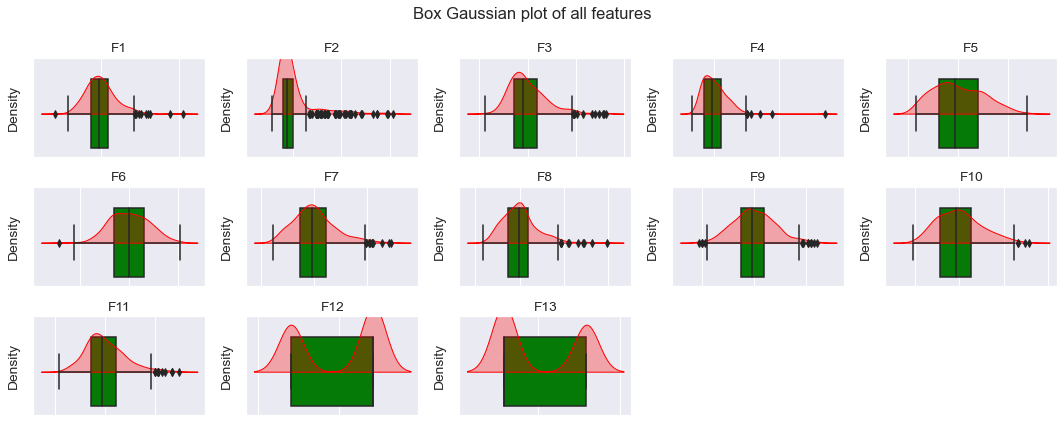

In [30]:
data_plot (data,
          Pair_plot=False,
          Dist_Plot=True,
          Plot_violinplot=False,
          Plot_confusionMatrix=True,
          box_Gaussian=True)

## Data prepossessing
Next, we can see from the plots above that many features have outliers or quite skewed. We did experiments on outlier rejection using different methods including manual, iqr and so on. We used log transformation and standardization to remove skewness. We also did experiments of feature selection using pca, ica and correlation based method.

In [35]:

# manual outlier rejection
def Manual (data):

    for i in range(2):                                     
      max_f1 = data.F1.max() 
      data = data[data.F1!=max_f1]
 
        
    for i in range(10):                                     
      max_f2 = data.F2.max() 
      data = data[data.F2!=max_f2]

    for i in range(5):                                     
      max_f3 = data.F3.max() 
      data = data[data.F3!=max_f3]
    for i in range(3):                                     
      min_f3 = data.F3.min() 
      data = data[data.F3!=min_f3]
    
    
    for i in range(4):                                     
      max_f4 = data.F4.max() 
      data = data[data.F4!=max_f4]
    
    for i in range(2):                                     
      min_f6 = data.F6.min() 
      data = data[data.F6!=min_f6]

    for i in range(1):                                     
      max_f7 = data.F7.max() 
      data = data[data.F7!=max_f7]

    for i in range(2):                                     
      max_f8 = data.F8.max() 
      data = data[data.F8!=max_f8]
  
    
    return data




# replace outliers with median value based on iqr
def IQR_Median (data): 

 
  for i in range(8):
    x = data[Renamed_feature[i]]
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3-Q1
    median = x.quantile(0.5)                               
    for j in range(569):                                    
      temp = x[j]
      LW = (Q1 - 1.5 * IQR)
      UW = (Q3 + 1.5 * IQR)
      if temp < LW:                                         
        x[j] = median
      if temp > UW:
        x[j] = median                                       
    data[Renamed_feature[i]] = x
  return data



# reject the outliers based on iqr
def IQR (data):
  # defined the features for outlier rejection
  Renamed_feature = ['F1','F4','F5','F7','F10','F11']
  for i in range(len(Renamed_feature)):  
    Q1 = data[Renamed_feature[i]].quantile(0.25)
    Q3 = data[Renamed_feature[i]].quantile(0.75)
    IQR = Q3-Q1                                             
    LW = (Q1 - 1.5 * IQR)                                   
    UW = (Q3 + 1.5 * IQR)                                   
    data = data[data[Renamed_feature[i]]<UW]                
    data = data[data[Renamed_feature[i]]>LW]               

  return data



# define the outlier rejection function for experiments
def outlier_Rejection (data, iqr_Mean, iqr_Medain, iqr, manual):
  if iqr_Mean == True:                                    
    data = IQR_Mean (data)
  if iqr_Medain == True:                                  
    data = IQR_Medain (data)
  if iqr == True:                                          
    data = IQR (data)
  if manual == True:                                       
    data = Manual (data)

  return data


def metrics (y_true, y_pred, probas_):
  points=n_dots*'-'
  print(points)
  fpr, tpr, thresholds = roc_curve(y_true, probas_[:, 1])
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
  roc_auc = auc(fpr, tpr)
  print("Detailed classification report for current fold:")
  print()
  print(classification_report(y_true, y_pred))
  print()
  print("Area Under ROC (AUC): {}".format(roc_auc))
  print()
  print('Confusion Matrix for current fold: ')
  print(confusion_matrix(y_true, y_pred))
  print()
  print("Accuracy for Current Fold: {}".format(accuracy_score(y_true, y_pred)))
  print()
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  return  tn, fp, fn, tp, roc_auc, fpr, tpr


def average_ROC(mean_fpr,tprs,aucs,TP,TN,FP,FN):

  
  sen = (np.sum(TP))/(np.sum(TP)+np.sum(FN))
  spe = (np.sum(TN))/(np.sum(TN)+np.sum(FP))

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  # mean_auc = auc(mean_fpr, mean_tpr)
  mean_auc = np.mean(aucs)
  std_auc = np.std(aucs)
  # plt.figure(figsize=(8, 5))
  # plt.grid(True)
  ax = plt.axes()
  ax.grid(color='lightgray', linestyle='-', linewidth=.5)
  # Setting the background color
  ax.set_facecolor("white")
  
  ax.spines['bottom'].set_color('#000000')
  ax.spines['top'].set_color('#000000') 
  ax.spines['right'].set_color('#000000')
  ax.spines['left'].set_color('#000000')

  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Avg. ROC (AUC (avg $\pm$ std) = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)
  
  plt.scatter((1-spe), sen, s=80, c='r', marker='x',)
  plt.scatter(0, sen, s=80, c='r', marker='x',)
  plt.scatter((1-spe),0, s=80, c='r', marker='x',)
  plt.axhline(y=sen, color='r', linestyle='--')
  plt.axvline(x=(1-spe), color='r', linestyle='--')
  plt.text((1-spe), 0.02, "FPR={:0.3f}".format((1-spe)))
  plt.text(0.009, sen+0.05, "TPR={:0.3f}".format(sen))

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='darkgray', alpha=0.5,
                  label=r'$\pm$ 1 Standard deviation')

  plt.xticks(np.arange(0.0, 1.01, step=0.1))
  plt.yticks(np.arange(0.0, 1.01, step=0.1))
  left=0.0
  right=1.0
  plt.xlim(left, right)
  plt.ylim(left, right)
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc="lower right")
  plt.show()

def plot_Current_ROC(fpr,tpr,iterator,roc_auc):

  plt.plot(fpr,
          tpr,
          alpha=0.35,
          linewidth=1)
   

   
def creat_Model (classifier, X_Train, Y_Train, tuned_parameters, verbose):

  clf = GridSearchCV(classifier,
                    tuned_parameters,
                    verbose=verbose,
                    cv=5,
                    scoring='roc_auc',
                    n_jobs=-1)
  clf.fit(X_Train, Y_Train)
  return clf


def average_performance(aucs,Accuracy,TP,TN,FP,FN): 
  print()
  n_dotsav=(n_dots-len('Average'))//2   
  print('-'*n_dotsav+'Average'+'-'*n_dotsav)
  print("AUC (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(aucs),np.std(aucs)))
  print("Accuracy (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(Accuracy),np.std(Accuracy)))
  cm = [[int(np.mean(TP)), int(np.mean(FP))],[int(np.mean(FN)), int(np.mean(TN))]]
  print ('Avg. CM is '+str(cm))
  cm = [[int(np.sum(TP)), int(np.sum(FP))],[int(np.sum(FN)), int(np.sum(TN))]]
  print ('Total for all folds CM is '+str(cm))
  re_auc=str(round(np.mean(aucs), 3))+'+/-'+str(round(np.std(aucs),3))
  all_clf_res.append(re_auc)
    

def feature_Selector(data, algo, n_feature):
    
    if algo=='PCA': 
        X_Data= data.iloc[:,:13].values
        pca = PCA(n_components=n_feature)                             
        X_Data = pca.fit_transform(X_Data)
        return X_Data , data.iloc[:,13:].values

    if algo == 'ICA':
        X_Data= data.iloc[:,:13].values
        ICA = FastICA(n_components=n_feature, random_state=12) 
        X_Data = ICA.fit_transform(X_Data)
        return X_Data , data.iloc[:,13:].values
    
    if algo =='corr':                                                   
        if n_feature == 10:
            data = data[['F1','F2','F4','F5','F6','F7','F8','F9','F10','F11','Outcome']]                
            return data.iloc[:,:10].values, data.iloc[:,10:].values
        if n_feature == 9:
            data = data[['F1','F2','F4','F5','F7','F8','F9','F10','F11','Outcome']]                
            return data.iloc[:,:9].values, data.iloc[:,9:].values
        if n_feature == 8:
            data = data[['F1','F2','F4','F5','F7','F8','F10','F11','Outcome']]       
            return data.iloc[:,:8].values, data.iloc[:,8:].values
        
    if algo == 'None':
        return data.iloc[:,:13].values, data.iloc[:,13:].values            #if feature selection is off all features are counted

# Data Preprocessing  

### Outlier rejection

In [36]:
# outlier rejection using iqr method
data = outlier_Rejection (data,
                  iqr_Mean=False,
                  iqr_Medain=False,
                  iqr=True,
                  manual=False)
print('Shape After outlier Removed: ' + str(data.shape))


Shape After outlier Removed: (356, 14)


### Log transformation

In [37]:
# log transformation to remove skewness
data['F2'] = data['F2'].apply(lambda x: np.log(x))
data['F3'] = data['F3'].apply(lambda x: np.log(x))
data['F4'] = data['F4'].apply(lambda x: np.log(x))
data['F7'] = data['F7'].apply(lambda x: np.log(x))
data['F8'] = data['F8'].apply(lambda x: np.log(x))
data['F9'] = data['F8'].apply(lambda x: np.log(x))
data['F10'] = data['F8'].apply(lambda x: np.log(x))

### 5 fold cross validation

In [38]:
kf = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=100)

### Feature selection 

In [39]:
X_Data,Y_Lavel = feature_Selector(data, algo='corr', n_feature=9)  

### Standardization

In [40]:
scaler =  preprocessing.StandardScaler()
X_Data,Y_Lavel= scaler.fit_transform(X_Data), Y_Lavel  

### Processed Data Plot and Presenation

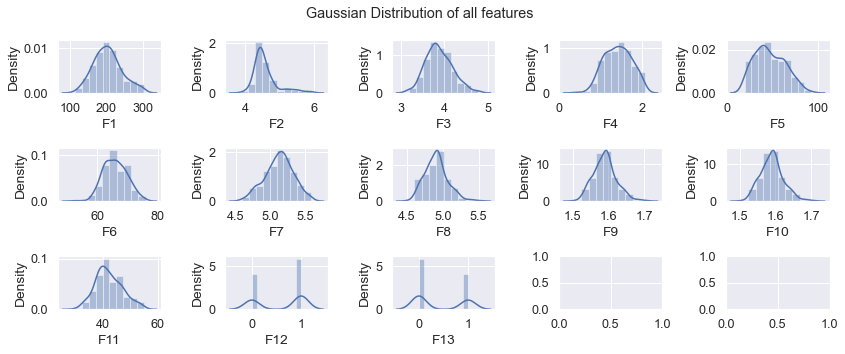

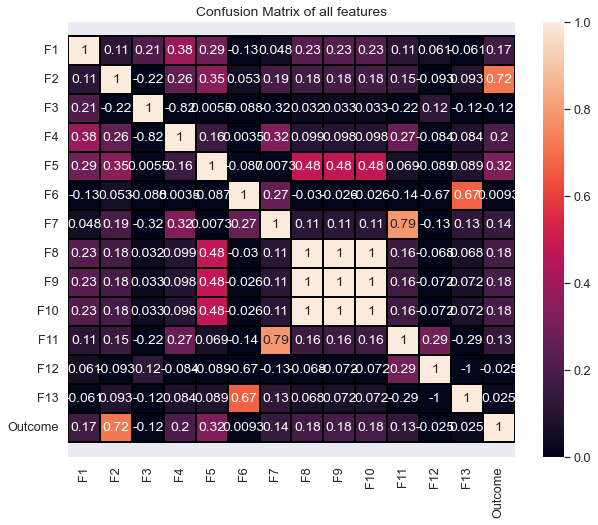

In [37]:
data_plot (data,
          Pair_plot=False,
          Dist_Plot=True,
          Plot_violinplot=False,
          Plot_confusionMatrix=True,
          box_Gaussian=False)

We can see that the correlation for many features to the outcome improved, and the distribution is more normal than the raw data.

## Analyzing KNN model

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93        62
         1.0       0.00      0.00      0.00        10

    accuracy                           0.86        72
   macro avg       0.43      0.50      0.46        72
weighted avg       0.74      0.86      0.80        72


Area Under ROC (AUC): 0.8596774193548387

Confusion Matrix for current fold: 
[[62  0]
 [10  0]]

Accuracy for Current Fold: 0.8611111111111112

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94        61
         1.0       1.00      0.20      0.33        10

    accuracy                           0.89        71
   macro avg       0.94      0.60      0.64        71
weighted avg       0.90      0.89      0.85        71

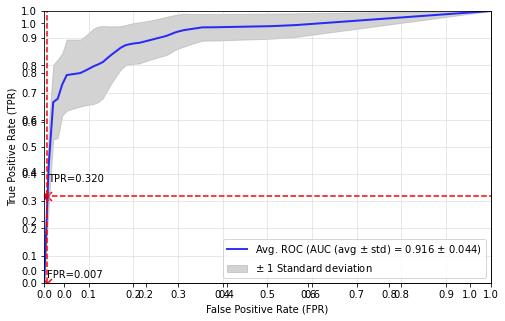


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.916 +/- 0.044
Accuracy (Avg. +/- Std.) is  0.899 +/- 0.024
Avg. CM is [[3, 0], [6, 60]]
Total for all folds CM is [[16, 2], [34, 304]]


In [41]:
Accuracy = []                                                                
FP = []                                                                     
TN = []                                                                    
FN = []                                                                     
TP = []                                                                     
tprs = []                                                                    
aucs_kNN = []                                                               
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))

for train_index, test_index in kf.split(X_Data,Y_Lavel):                     
    
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]               
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]             

    n_neighbors = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49]
    leaf_size = [5,10,15,20,25,30,35,40,45,50]
    Distance = [1,2]


    tuned_parameters = [ {'n_neighbors': n_neighbors,                        
                        'algorithm' : ['brute'],
                        'p':Distance},

                         {'n_neighbors': n_neighbors, 
                        'algorithm' : ['ball_tree'],
                        'leaf_size' : leaf_size,
                        'p':Distance},

                        {'n_neighbors': n_neighbors, 
                        'algorithm' : ['kd_tree'],
                        'leaf_size' : leaf_size,
                        'p':Distance}]

    clf = creat_Model (classifier = KNeighborsClassifier(),                     
                      X_Train = X_Train,
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)

    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test,               
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))                                     
    tprs[-1][0] = 0.0
    aucs_kNN.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                                
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
average_ROC(mean_fpr,tprs,aucs_kNN,TP,TN,FP,FN)                                 
average_performance(aucs_kNN,Accuracy,TP,TN,FP,FN)                             

## Analyzing  Decision Trees Classifier

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        62
         1.0       1.00      0.50      0.67        10

    accuracy                           0.93        72
   macro avg       0.96      0.75      0.81        72
weighted avg       0.94      0.93      0.92        72


Area Under ROC (AUC): 0.9137096774193548

Confusion Matrix for current fold: 
[[62  0]
 [ 5  5]]

Accuracy for Current Fold: 0.9305555555555556

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        61
         1.0       0.80      0.80      0.80        10

    accuracy                           0.94        71
   macro avg       0.88      0.88      0.88        71
weighted avg       0.94      0.94      0.94        71

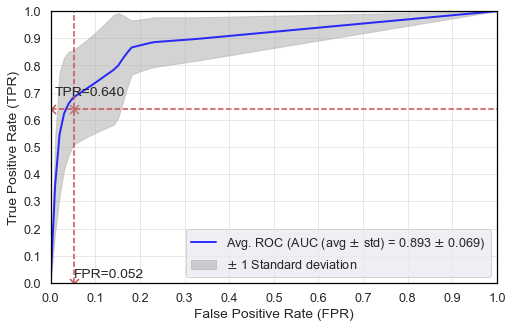


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.893 +/- 0.069
Accuracy (Avg. +/- Std.) is  0.904 +/- 0.038
Avg. CM is [[6, 3], [3, 58]]
Total for all folds CM is [[32, 16], [18, 290]]


In [29]:
Accuracy = []                                                               
FP = []                                                                     
TN = []                                                                      
FN = []                                                                     
TP = []                                                                     
tprs = []                                                                    
aucs_Tree = []                                                              
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))

for train_index, test_index in kf.split(X_Data,Y_Lavel):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

                                                                            

    tuned_parameters = {'criterion': ['gini','entropy'],
                       'splitter': ['best'],
                       'min_samples_split':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                       'min_samples_leaf': [1,2,3,4,5] }

    clf = creat_Model (classifier = DecisionTreeClassifier( random_state=random_initializer),
                      X_Train = X_Train,                                   
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters,
                      verbose=0)

    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test,          
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_Tree.append(roc_auc)                                               
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
average_ROC(mean_fpr,tprs,aucs_Tree,TP,TN,FP,FN)                            
average_performance(aucs_Tree,Accuracy,TP,TN,FP,FN)                          

## Analyzing Random Forest Classifier

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97        62
         1.0       0.88      0.70      0.78        10

    accuracy                           0.94        72
   macro avg       0.91      0.84      0.87        72
weighted avg       0.94      0.94      0.94        72


Area Under ROC (AUC): 0.9161290322580645

Confusion Matrix for current fold: 
[[61  1]
 [ 3  7]]

Accuracy for Current Fold: 0.9444444444444444

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        61
         1.0       0.90      0.90      0.90        10

    accuracy                           0.97        71
   macro avg       0.94      0.94      0.94        71
weighted avg       0.97      0.97      0.97        71

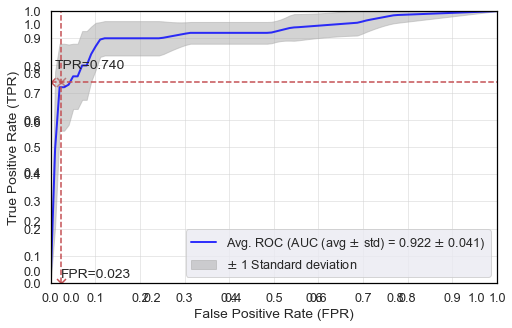


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.922 +/- 0.041
Accuracy (Avg. +/- Std.) is  0.944 +/- 0.025
Avg. CM is [[7, 1], [2, 59]]
Total for all folds CM is [[37, 7], [13, 299]]


In [28]:
Accuracy = []                                                               
FP = []                                                                    
TN = []                                                                      
FN = []                                                                      
TP = []                                                                     
tprs = []                                                                   
aucs_Forest = []                                                            
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))

for train_index, test_index in kf.split(X_Data,Y_Lavel):                     

    X_Train, X_Test = X_Data[train_index], X_Data[test_index]                
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              

    tuned_parameters = {'criterion': ['gini','entropy']}

    clf = creat_Model (classifier = RandomForestClassifier( random_state=random_initializer),
                      X_Train = X_Train,                                     
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)

    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test,              
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_Forest.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                              
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
average_ROC(mean_fpr,tprs,aucs_Forest,TP,TN,FP,FN)                          
average_performance(aucs_Forest,Accuracy,TP,TN,FP,FN)                         

## Analyzing AdaBoost Classifier

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        62
         1.0       1.00      0.50      0.67        10

    accuracy                           0.93        72
   macro avg       0.96      0.75      0.81        72
weighted avg       0.94      0.93      0.92        72


Area Under ROC (AUC): 0.9193548387096775

Confusion Matrix for current fold: 
[[62  0]
 [ 5  5]]

Accuracy for Current Fold: 0.9305555555555556

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        61
         1.0       0.80      0.80      0.80        10

    accuracy                           0.94        71
   macro avg       0.88      0.88      0.88        71
weighted avg       0.94      0.94      0.94        71

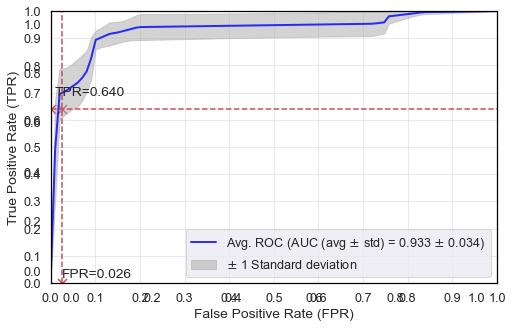


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.933 +/- 0.034
Accuracy (Avg. +/- Std.) is  0.927 +/- 0.024
Avg. CM is [[6, 1], [3, 59]]
Total for all folds CM is [[32, 8], [18, 298]]


In [27]:
Accuracy = []                                                                
FP = []                                                                     
TN = []                                                                     
FN = []                                                                      
TP = []                                                                      
tprs = []                                                                   
aucs_aBoost = []                                                             

mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))


for train_index, test_index in kf.split(X_Data,Y_Lavel):                     
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]                
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              
    tuned_parameters = { 'algorithm': ['SAMME','SAMME.R'],
                       'learning_rate':[0.1,0.5,1.0],
                       'n_estimators': [10,50,100,200]}

    
    clf = creat_Model (classifier = AdaBoostClassifier( random_state=random_initializer),
                      X_Train = X_Train,                                      
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),            
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_aBoost.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                              
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test.ravel(), clf.predict(X_Test)))
average_ROC(mean_fpr,tprs,aucs_aBoost,TP,TN,FP,FN)                           
average_performance(aucs_aBoost,Accuracy,TP,TN,FP,FN)                        

## Analyzing Naive Bayes Model

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94        62
         1.0       0.71      0.50      0.59        10

    accuracy                           0.90        72
   macro avg       0.82      0.73      0.77        72
weighted avg       0.89      0.90      0.90        72


Area Under ROC (AUC): 0.9306451612903226

Confusion Matrix for current fold: 
[[60  2]
 [ 5  5]]

Accuracy for Current Fold: 0.9027777777777778

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        61
         1.0       0.77      1.00      0.87        10

    accuracy                           0.96        71
   macro avg       0.88      0.98      0.92        71
weighted avg       0.97      0.96      0.96        71

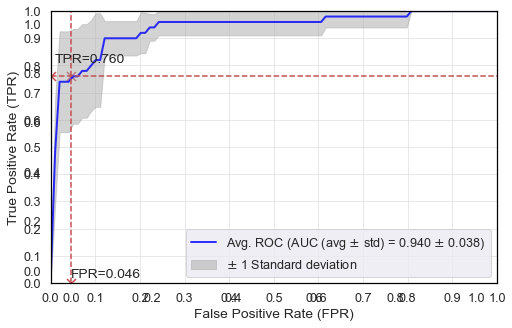


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.940 +/- 0.038
Accuracy (Avg. +/- Std.) is  0.927 +/- 0.022
Avg. CM is [[7, 2], [2, 58]]
Total for all folds CM is [[38, 14], [12, 292]]


In [26]:
Accuracy = []                                                               
FP = []                                                                      
TN = []                                                                      
FN = []                                                                      
TP = []                                                                     
tprs = []                                                                    
aucs_NB = []                                                                 
iterator=0

mean_fpr = np.linspace(0, 1, 100) 
fig = plt.figure(figsize=(8, 5))


for train_index, test_index in kf.split(X_Data,Y_Lavel):                     
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]               
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]             

    var_smoothing = [1e-01,
                    1e-02,
                    1e-03,
                    1e-04,
                    1e-05,
                    1e-06,
                    1e-07,
                    1e-08,
                    1e-09,
                    1e-10,
                    1e-11,
                    1e-12]

    tuned_parameters = [{'var_smoothing': var_smoothing}]

    clf = creat_Model (classifier = GaussianNB(),                            
                      X_Train = X_Train,
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),            
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_NB.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                              
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
average_ROC(mean_fpr,tprs,aucs_NB,TP,TN,FP,FN)                             
average_performance(aucs_NB,Accuracy,TP,TN,FP,FN)                            

## Analyzing XGBoost Model

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        62
         1.0       1.00      0.60      0.75        10

    accuracy                           0.94        72
   macro avg       0.97      0.80      0.86        72
weighted avg       0.95      0.94      0.94        72


Area Under ROC (AUC): 0.9653225806451613

Confusion Matrix for current fold: 
[[62  0]
 [ 4  6]]

Accuracy for Current Fold: 0.9444444444444444

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        61
         1.0       1.00      0.80      0.89        10

    accuracy                           0.97        71
   macro avg       0.98      0.90      0.94        71
weighted avg       0.97      0.97      0.97        71

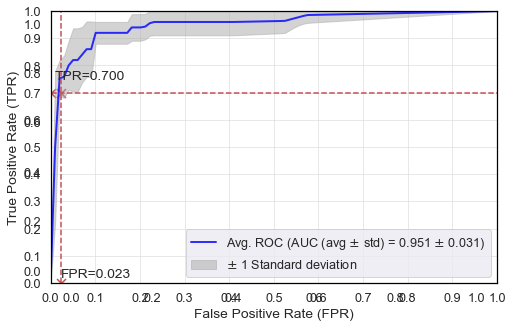


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.951 +/- 0.031
Accuracy (Avg. +/- Std.) is  0.938 +/- 0.021
Avg. CM is [[7, 1], [3, 59]]
Total for all folds CM is [[35, 7], [15, 299]]
Sensitivity (Avg. +/- Std.) is  0.700 +/- 0.141
Specificity (Avg. +/- Std.) is  0.977 +/- 0.030
Precision (Avg. +/- Std.) is  0.870 +/- 0.132
FOR (Avg. +/- Std.) is  0.047 +/- 0.021
DOR (Avg. +/- Std.) is  inf +/- nan


In [23]:
Accuracy = []                                                               
FP = []                                                                      
TN = []                                                                      
FN = []                                                                     
TP = []                                                                     
tprs = []                                                                    
aucs_xboost = []                                                              
sn = []                                                                     
sp = []                                                                     
pr = []                                                                    
FOR = []                                                                     
DOR = []                                                                    
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))


for train_index, test_index in kf.split(X_Data,Y_Lavel):                     
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]                
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              

    tuned_parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

    clf = creat_Model (classifier = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'error', random_state=random_initializer,use_label_encoder=False),
                      X_Train = X_Train,                                        
                      Y_Train = Y_Train.ravel(),
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),               
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_xboost.append(roc_auc)
    plot_Current_ROC(fpr,tpr,iterator,roc_auc)                                 
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    sn.append(tp/(tp+fn))
    sp.append(tn/(fp+tn))
    pr.append(tp/(tp+fp))
    FOR.append(fn/(tn+fn))
    DOR.append((tp*tn)/(fp*fn))

average_ROC(mean_fpr,tprs,aucs_xboost,TP,TN,FP,FN)                              
average_performance(aucs_xboost,Accuracy,TP,TN,FP,FN)                          

print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))

In [24]:
# define ensembler
def Ensembler(n_model, X_Train, Y_Train, X_Test, Y_Test, weight):
                                                       
    n_neighbors = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49]
    leaf_size = [5,10,15,20,25,30,35,40,45,50]
    Distance = [1,2]
                                                                     
    tuned_parameters_knn = [ {'n_neighbors': n_neighbors, 
                        'algorithm' : ['brute'],
                        'p':Distance},
                         
                         {'n_neighbors': n_neighbors, 
                        'algorithm' : ['ball_tree'],
                        'leaf_size' : leaf_size,
                        'p':Distance},
                          
                        {'n_neighbors': n_neighbors, 
                        'algorithm' : ['kd_tree'],
                        'leaf_size' : leaf_size,
                        'p':Distance}]

    clf_knn = creat_Model (classifier = KNeighborsClassifier(),             
                      X_Train = X_Train,
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters_knn,
                      verbose=0)
    
    tuned_parameters_ab = { 'algorithm': ['SAMME','SAMME.R'],         
                   'learning_rate':[0.1,0.5,1.0],
                   'n_estimators': [10,50,100,200]}

    clf_ab = creat_Model (classifier = AdaBoostClassifier(random_state=random_initializer),
                  X_Train = X_Train,                               
                  Y_Train = Y_Train,
                  tuned_parameters = tuned_parameters_ab,
                  verbose=0)
    
    tuned_parameters_dt = {'criterion': ['gini','entropy'],          
                       'splitter': ['best'],
                       'min_samples_split':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                       'min_samples_leaf': [1,2,3,4,5] }

    clf_dt = creat_Model (classifier = DecisionTreeClassifier(random_state=random_initializer),
                      X_Train = X_Train,                            
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters_dt,
                      verbose=0)
    
    tuned_parameters_rf = {'criterion': ['gini','entropy']}          

    clf_rf = creat_Model (classifier = RandomForestClassifier(random_state=random_initializer),
                      X_Train = X_Train,                            
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters_rf,
                      verbose=0)
    
    var_smoothing = [1e-01,
                    1e-02,
                    1e-03,
                    1e-04,
                    1e-05,
                    1e-06,
                    1e-07,
                    1e-08,
                    1e-09,
                    1e-10,
                    1e-11,
                    1e-12]

    tuned_parameters_nb = [{'var_smoothing': var_smoothing}]         

    clf_nb = creat_Model (classifier = GaussianNB(),                 
                      X_Train = X_Train,
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters_nb,
                      verbose=0)
    tuned_parameters_xb = {                                          
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

        
    clf_xb = creat_Model (classifier = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'error',random_state=random_initializer,use_label_encoder=False),
                      X_Train = X_Train,                              
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters_xb,
                      verbose=0)
    
    
    if weight == 'None':                                             
        if n_model == 2:                                              
            model = VotingClassifier([('ab', clf_ab), 
                                      ('xb', clf_xb)], 
                                     voting='soft')
            model.fit(X_Train,Y_Train)
            return model 


## Analyzing  AB + XGboost with soft voting

++++++++++++++++++++++++++++++++++++++++++++++++++
model running with ensembling  ---  2  models
++++++++++++++++++++++++++++++++++++++++++++++++++
--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        62
         1.0       1.00      0.60      0.75        10

    accuracy                           0.94        72
   macro avg       0.97      0.80      0.86        72
weighted avg       0.95      0.94      0.94        72


Area Under ROC (AUC): 0.9604838709677419

Confusion Matrix for current fold: 
[[62  0]
 [ 4  6]]

Accuracy for Current Fold: 0.9444444444444444

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        61
         1.0       1.00      0.80      0.89        10

    accuracy 

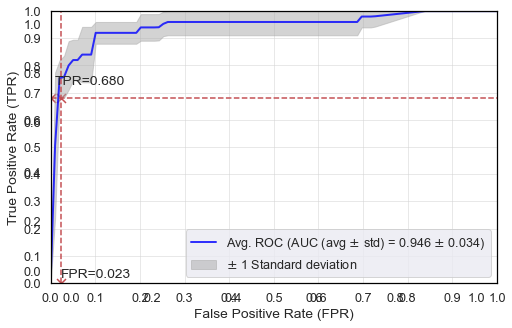


---------------------Average---------------------
AUC (Avg. +/- Std.) is  0.946 +/- 0.034
Accuracy (Avg. +/- Std.) is  0.935 +/- 0.021
Avg. CM is [[6, 1], [3, 59]]
Total for all folds CM is [[34, 7], [16, 299]]
Sensitivity (Avg. +/- Std.) is  0.680 +/- 0.147
Specificity (Avg. +/- Std.) is  0.977 +/- 0.030
Precision (Avg. +/- Std.) is  0.867 +/- 0.132
FOR (Avg. +/- Std.) is  0.050 +/- 0.022
DOR (Avg. +/- Std.) is  inf +/- nan


In [25]:
from sklearn.ensemble import VotingClassifier
i=2
Accuracy = []                                                                
FP = []                                                                     
TN = []                                                                     
FN = []                                                                      
TP = []                                                                    
tprs = []                                                                    
aucs_ens = []                                                               
sn = []                                                                     
sp = []                                                                    
pr = []                                                                     
FOR = []                                                                    
DOR = []                                                                     
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))


plus_print=n_dots*'+'
print(plus_print)
print('model running with ensembling  ---  '+str(i )+'  models')
print(plus_print)


for train_index, test_index in kf.split(X_Data,Y_Lavel):                   

    X_Train, X_Test = X_Data[train_index], X_Data[test_index]               
    Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]             


    clf = Ensembler( i, X_Train, Y_Train.ravel(), X_Test, Y_Test.ravel(), 'None')          

    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test.ravel(),         
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0                                           
    aucs_ens.append(roc_auc)
    plot_Current_ROC (fpr,tpr,iterator,roc_auc)                             
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test.ravel(), clf.predict(X_Test)))
    sn.append(tp/(tp+fn))
    sp.append(tn/(fp+tn))
    pr.append(tp/(tp+fp))
    FOR.append(fn/(tn+fn))
    DOR.append((tp*tn)/(fp*fn))

average_ROC(mean_fpr,tprs,aucs_ens,TP,TN,FP,FN)                             
average_performance(aucs_ens,Accuracy,TP,TN,FP,FN)  


print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))
